# Model Trainer

This notebook will take our image located at base directory, train a model, and then test the performance of that model.

In [1]:
#Import packages
import os  
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import inspect
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-02 01:39:03.018994: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))
HOME_DIR = "/home/billiam/Documents/Repos/Lego-Brick-Sorter/"
os.chdir(HOME_DIR)
print(os.getcwd())

tf.Tensor(1051.4266, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/home/billiam/Documents/Repos/Lego-Brick-Sorter


<br></br>
**DISTRIBUTE IMAGES TO TRAINING, VALIDATION, AND TEST FOLDERS**

In [3]:
BASE_DIR = HOME_DIR + 'data/'
print(BASE_DIR)
names = ["3003", "3004", "3021", "6091"]
percentTraining = 0.75
percentValidation = 0.25

#Test set is defined as 0% since we will be using our own real images to test model in end, rather than synthetic data

tf.random.set_seed(1)

/home/billiam/Documents/Repos/Lego-Brick-Sorter/data/


In [4]:
# Reorganize the folder structure:
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)
        
# Move the image files
orig_folders = [name + "/" for name in names]
for folder_idx, folder in enumerate(orig_folders):
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len([name for name in files])
    n_train = int((number_of_images * percentTraining) + 0.5)
    n_valid = int((number_of_images* percentValidation) + 0.5)
    n_test = number_of_images - n_train - n_valid
    print(number_of_images, n_train, n_valid, n_test)
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file
        if idx < n_train:
            shutil.move(file_name, BASE_DIR + "train/" + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + "val/" + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + "test/" + names[folder_idx])

1000 750 250 0
1000 750 250 0
1000 750 250 0
1000 750 250 0


<br></br>
**CREATE OUR PRE-TRAINED MODEL WITH ONLY A FINAL TRAINABLE LAYER**

In [5]:
# From our previous test (447 5 class data set, our best performer was DenseNet169, so will use that here)
pre_model = tf.keras.applications.DenseNet169(include_top=False)
preprocess_fxn = tf.keras.applications.densenet.preprocess_input

In [6]:
# Compile our pre-trained model without last layer with a single trainable final layer

NUM_CLASSES = len(names)

# Create our empty model (look up sequential vs functional)
model = keras.models.Sequential()

# Add all layers from our pre-trained model (last layer already deleted from include_top=False)
model.add(pre_model)

# Make all remaining layers untrainable and add our last trainable layer
for layer in model.layers:
    layer.trainable = False
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(NUM_CLASSES))

# Loss and optimizer functions
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)

# Might try mean average precision for metric because we are categorizing so many classes
metrics = ["accuracy"]

# Used to do accuracy but someone online recommended MAP
# https://www.reddit.com/r/learnmachinelearning/comments/xpyv8j/data_set_for_lego_image_classification_800000/
# metrics = ["accuracy"]

# Compile our model
model.compile(optimizer=optim, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 6,660
Non-trainable params: 12,642,880
_________________________________________________________________


<br></br>
**CREATE TENSORFLOW IMAGE DATA BATCHES WITH PREPROCESSING AND TRAIN OUR MODEL**

In [78]:
train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn,
                                                        horizontal_flip = True,
                                                        vertical_flip = True,
                                                        rotation_range = 360,
                                                        #brightness_range = (0.1, 1), channel was 150
                                                        channel_shift_range=50.0,
                                                        fill_mode = 'wrap'
                                                        )
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_fxn)

train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

epochs = 25

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

print("Start training:")
model.summary()
model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2, shuffle=True)

model.save(HOME_DIR + "models/" + "full_synthetic_model_img_augmentation")

Found 3000 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Start training:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, None, None, 1664)  12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 6660      
                                                                 
Total params: 12,649,540
Trainable params: 6,660
Non-trainable params: 12,642,880
_________________________________________________________________
Epoch 1/25
750/750 - 26s - loss: 0.9939 - accuracy: 0.8260 - val_loss: 0.3856 - val_accuracy: 0.9250 - 26s/epoch - 35ms/step
Epoch 2/25
75

INFO:tensorflow:Assets written to: /home/billiam/Documents/Repos/Lego-Brick-Sorter/models/full_synthetic_model_img_augmentation/assets


INFO:tensorflow:Assets written to: /home/billiam/Documents/Repos/Lego-Brick-Sorter/models/full_synthetic_model_img_augmentation/assets


In [80]:
test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=names
)

print("Performance:")
model.evaluate(test_batches, verbose=2)

Found 1401 images belonging to 4 classes.
Performance:
351/351 - 8s - loss: 1.8453 - accuracy: 0.7516 - 8s/epoch - 23ms/step


[1.845337152481079, 0.7516059875488281]

In [30]:
#model = tf.keras.models.load_model(HOME_DIR + "full_synthetic_model")


def show(batch, num, pred_labels=None):
    for _ in range(num):
        img, label = batch.next()
        print(img.shape)
        print(type(img))
        clipFactor = img[0]/np.amax(img[0])
        clippedImg = np.clip(clipFactor, 0, 1)
        plt.imshow(clippedImg)
        #plt.imshow((img[0]*255).astype('uint8'))
        plt.show()
#     plt.figure(figsize=(10,10))
#     for i in range(4):
#         plt.subplot(2,2,i+1)
#         plt.xticks([])
#         plt.yticks([])
#         plt.grid(False)
#         plt.imshow((255 * batch[0][i]).astype(np.uint8), cmap=plt.cm.binary)
#         # The CIFAR labels happen to be arrays, 
#         # which is why you need the extra index
#         lbl = names[int(batch[1][i])]
#         if pred_labels is not None:
#             lbl += "/ Pred:" + names[int(pred_labels[i])]
#         plt.xlabel(lbl)
#     plt.show()
    
#plt.imshow(out.astype('uint8'))
    
# make some predictions
# predictions = model.predict(test_batches)
# predictions = tf.nn.softmax(predictions)
# labels = np.argmax(predictions, axis=1)

# print(test_batches[0][1])

# print(labels[0:4])

(4, 224, 224, 3)
<class 'numpy.ndarray'>


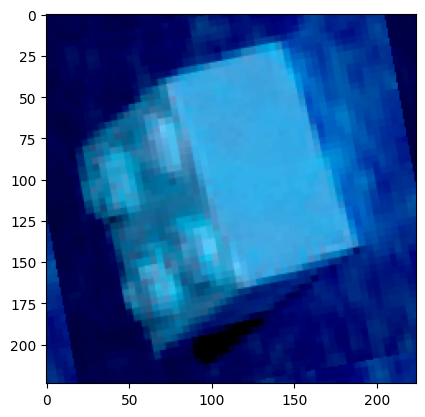

(4, 224, 224, 3)
<class 'numpy.ndarray'>


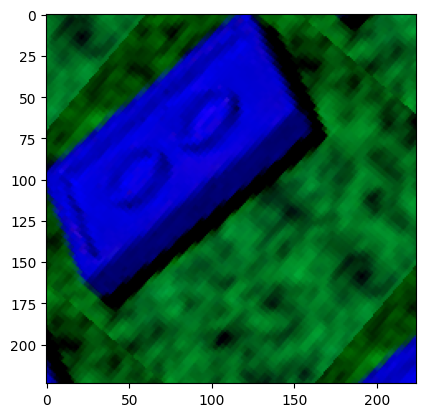

(4, 224, 224, 3)
<class 'numpy.ndarray'>


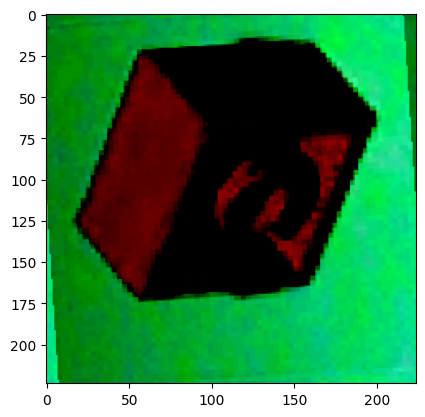

(4, 224, 224, 3)
<class 'numpy.ndarray'>


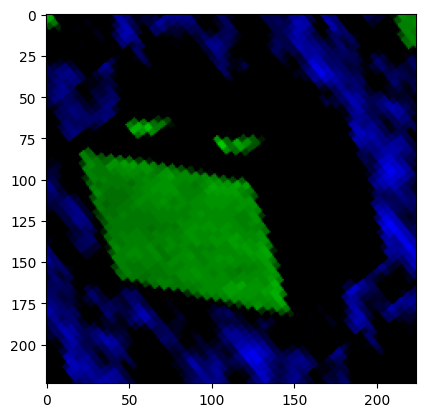

(4, 224, 224, 3)
<class 'numpy.ndarray'>


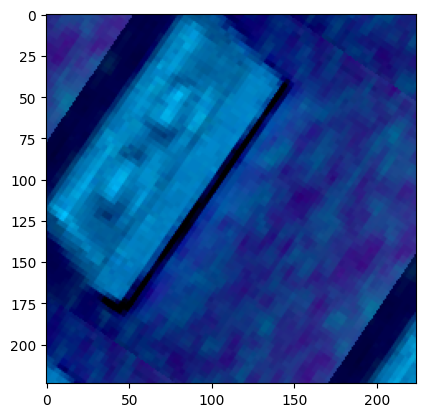

(4, 224, 224, 3)
<class 'numpy.ndarray'>


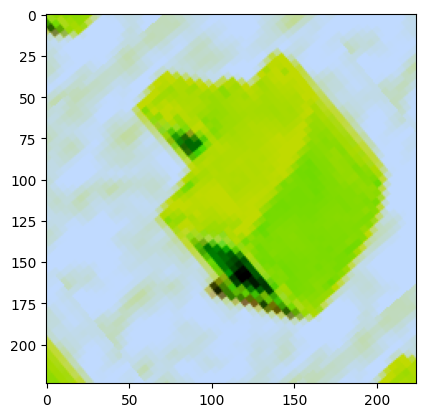

(4, 224, 224, 3)
<class 'numpy.ndarray'>


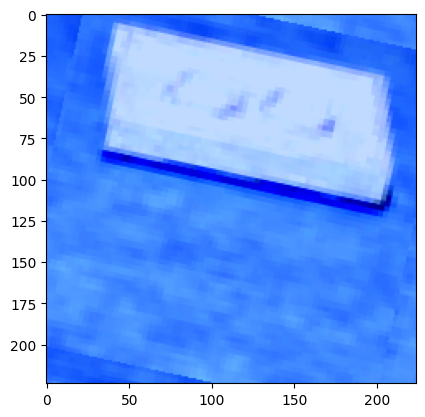

(4, 224, 224, 3)
<class 'numpy.ndarray'>


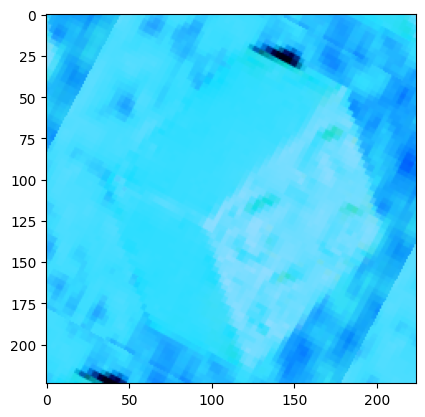

(4, 224, 224, 3)
<class 'numpy.ndarray'>


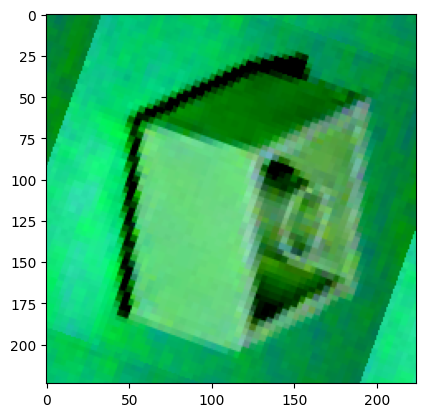

(4, 224, 224, 3)
<class 'numpy.ndarray'>


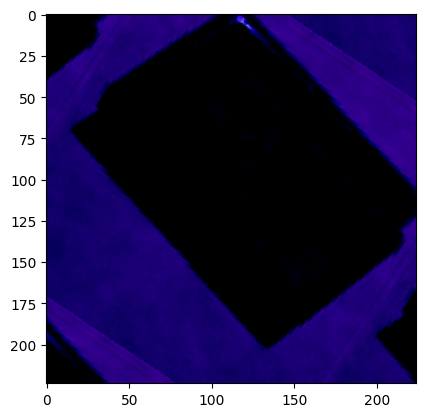

(4, 224, 224, 3)
<class 'numpy.ndarray'>


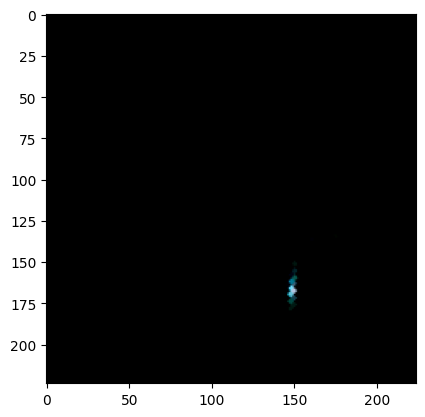

(4, 224, 224, 3)
<class 'numpy.ndarray'>


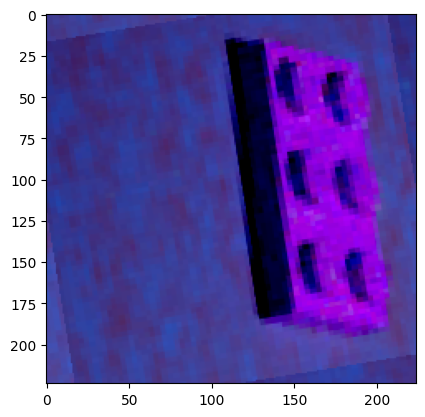

(4, 224, 224, 3)
<class 'numpy.ndarray'>


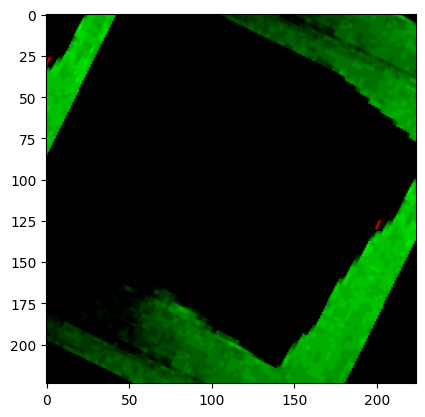

(4, 224, 224, 3)
<class 'numpy.ndarray'>


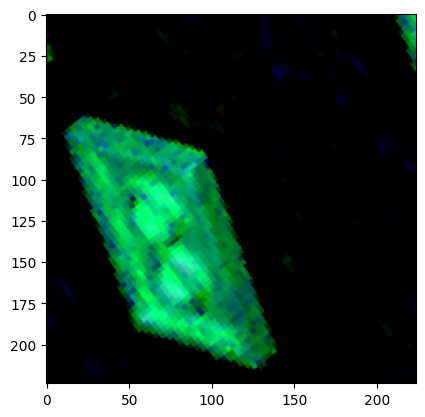

(4, 224, 224, 3)
<class 'numpy.ndarray'>


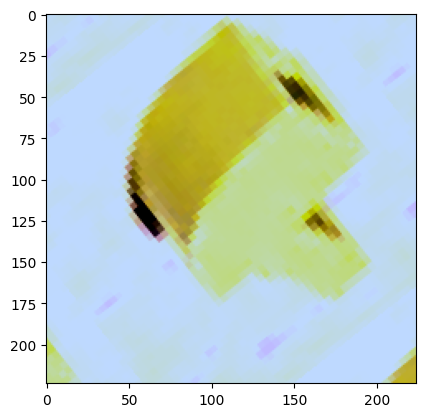

(4, 224, 224, 3)
<class 'numpy.ndarray'>


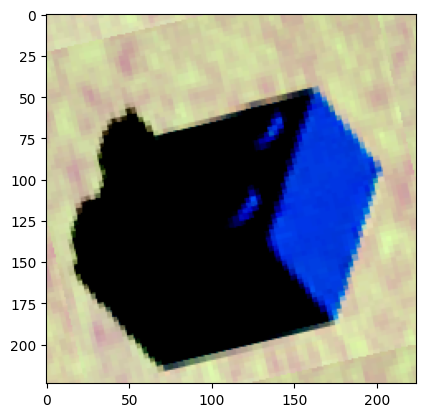

(4, 224, 224, 3)
<class 'numpy.ndarray'>


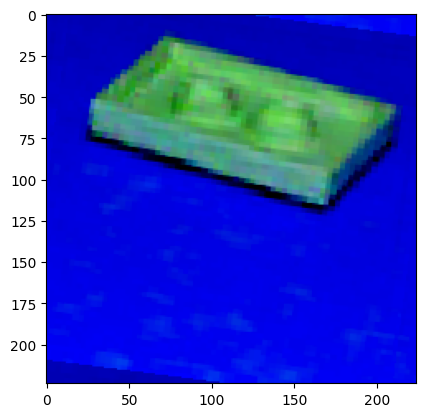

(4, 224, 224, 3)
<class 'numpy.ndarray'>


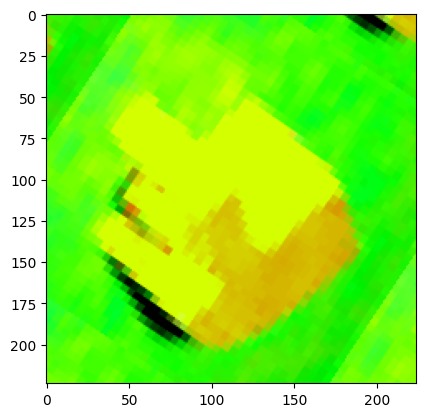

(4, 224, 224, 3)
<class 'numpy.ndarray'>


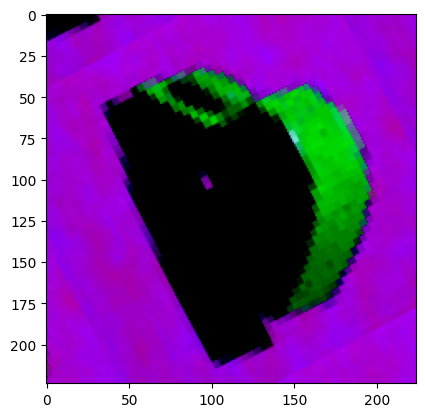

(4, 224, 224, 3)
<class 'numpy.ndarray'>


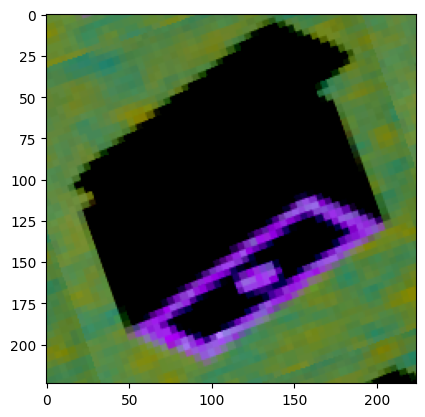

In [81]:
show(train_batches, 20)